# Multiclass Classfication model using CNN in Tensorflow

This project was done as part of the Master's in Data Science course from Liverpool John Moores University


**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset can be found here. This was project was done on Google colab.


### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Checking the current working directory
!pwd


/content


In [4]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2247
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Train dataset using seed =123

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2247 files belonging to 9 classes.
Using 1798 files for training.


In [8]:
## Validation dataset using seed =123

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123, 
    validation_split = 0.2,
    subset = 'validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2247 files belonging to 9 classes.
Using 449 files for validation.


In [9]:
# Listing out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


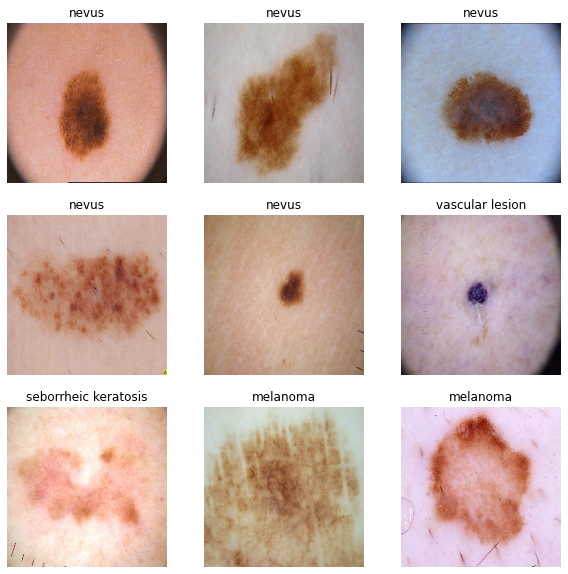

In [10]:
# Checking out some random images

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")





The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here

num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer 
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  #Downsampling
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size. 
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #Downsampling
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #Downsampling
  layers.MaxPooling2D(),

  #Flattening
  layers.Flatten(),

  #fully connected layer, also known as dense layer
  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes)
 
])



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:

#Adam. using Adam which is a recently proposed optimier 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        3

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 22s 90ms/step - loss: 2.0631 - accuracy: 0.2375 - val_loss: 1.8813 - val_accuracy: 0.2940
Epoch 2/20
57/57 [==============================] - 2s 37ms/step - loss: 1.6577 - accuracy: 0.4010 - val_loss: 1.5699 - val_accuracy: 0.4699
Epoch 3/20
57/57 [==============================] - 2s 36ms/step - loss: 1.4801 - accuracy: 0.4683 - val_loss: 1.4129 - val_accuracy: 0.5011
Epoch 4/20
57/57 [==============================] - 2s 36ms/step - loss: 1.4489 - accuracy: 0.4983 - val_loss: 1.4674 - val_accuracy: 0.5100
Epoch 5/20
57/57 [==============================] - 2s 36ms/step - loss: 1.2619 - accuracy: 0.5679 - val_loss: 1.4239 - val_accuracy: 0.5011
Epoch 6/20
57/57 [==============================] - 2s 37ms/step - loss: 1.1714 - accuracy: 0.5857 - val_loss: 1.4802 - val_accuracy: 0.4922
Epoch 7/20
57/57 [==============================] - 2s 36ms/step - loss: 1.1375 - accuracy: 0.5990 - val_loss: 1.3421 - val_accuracy: 0.5189
Epoch 8/20
5

### Visualizing training results

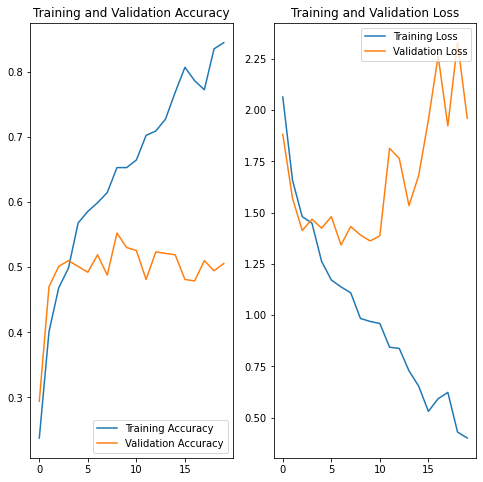

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:
We can see that difference between the training accuracy (close to 90%) and the validation accuracy (close to 50%) is way to high. And hence it can be be concluded that the model is overfitting.

In [18]:
# Using appropriate data augumentation strategy. 


data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomZoom(0.6),
    layers.experimental.preprocessing.RandomContrast(0.4),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None, fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

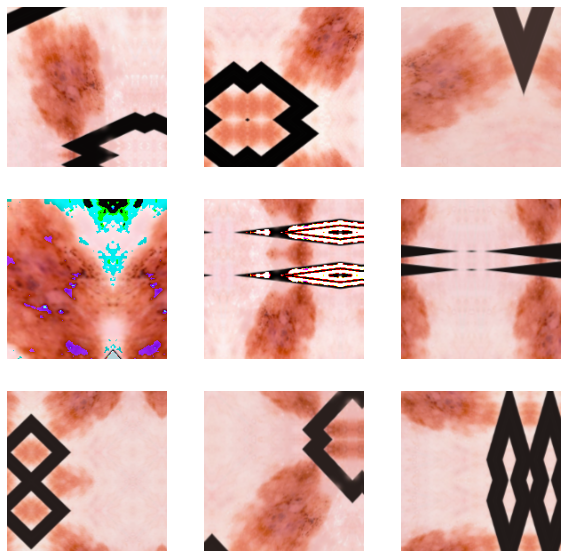

In [19]:
# Visualizing if the augmentation strategy has worked for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Inference : We can see different versions of the same image and hence can conclude that our image augmentation strategy has worked.


### Create the model, compile and train the model


In [20]:
## Unsing dropout later because of overfitting



model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [21]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [22]:


epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 8s 100ms/step - loss: 2.3673 - accuracy: 0.2280 - val_loss: 1.9371 - val_accuracy: 0.2450
Epoch 2/20
57/57 [==============================] - 5s 86ms/step - loss: 1.8596 - accuracy: 0.3265 - val_loss: 1.8216 - val_accuracy: 0.2895
Epoch 3/20
57/57 [==============================] - 5s 87ms/step - loss: 1.8250 - accuracy: 0.3237 - val_loss: 1.9344 - val_accuracy: 0.2851
Epoch 4/20
57/57 [==============================] - 5s 86ms/step - loss: 1.7515 - accuracy: 0.3571 - val_loss: 1.6768 - val_accuracy: 0.3608
Epoch 5/20
57/57 [==============================] - 5s 86ms/step - loss: 1.6648 - accuracy: 0.3904 - val_loss: 1.6465 - val_accuracy: 0.4009
Epoch 6/20
57/57 [==============================] - 5s 86ms/step - loss: 1.6587 - accuracy: 0.3810 - val_loss: 1.6117 - val_accuracy: 0.4053
Epoch 7/20
57/57 [==============================] - 5s 86ms/step - loss: 1.6355 - accuracy: 0.3904 - val_loss: 1.5836 - val_accuracy: 0.4143
Epoch 8/20
5

### Visualizing the results

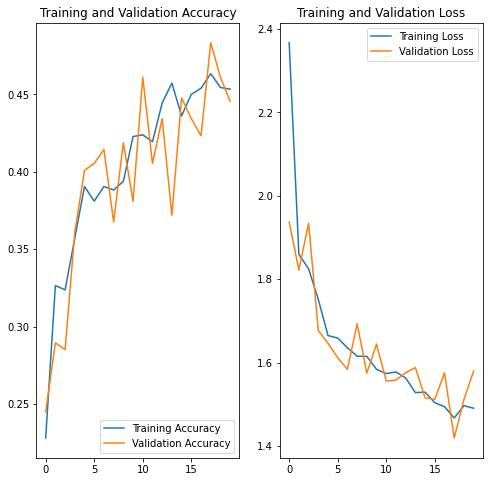

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



### Inference: 
We see that the validation accuracy  mostly follows the training accuracy, thus implying that the model is no longer overfitting. 
However, the overall accuracy of both training and validation set max outs at around 45%. Thus impying the model is not a good model yet, and hence needs futher improvement.

#### Find the distribution of classes in the training dataset.


In [24]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2247

In [25]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,gdrive/My Drive/CNN_assignment/Skin cancer ISI...,melanoma
1,gdrive/My Drive/CNN_assignment/Skin cancer ISI...,melanoma
2,gdrive/My Drive/CNN_assignment/Skin cancer ISI...,melanoma
3,gdrive/My Drive/CNN_assignment/Skin cancer ISI...,melanoma
4,gdrive/My Drive/CNN_assignment/Skin cancer ISI...,melanoma
...,...,...
2242,gdrive/My Drive/CNN_assignment/Skin cancer ISI...,pigmented benign keratosis
2243,gdrive/My Drive/CNN_assignment/Skin cancer ISI...,pigmented benign keratosis
2244,gdrive/My Drive/CNN_assignment/Skin cancer ISI...,pigmented benign keratosis
2245,gdrive/My Drive/CNN_assignment/Skin cancer ISI...,pigmented benign keratosis


class 3 : melanoma = 438 (19.493%)
class 4 : nevus = 357 (15.888%)
class 0 : actinic keratosis = 114 (5.073%)
class 8 : vascular lesion = 139 (6.186%)
class 6 : seborrheic keratosis = 77 (3.427%)
class 7 : squamous cell carcinoma = 181 (8.055%)
class 2 : dermatofibroma = 103 (4.584%)
class 1 : basal cell carcinoma = 376 (16.733%)
class 5 : pigmented benign keratosis = 462 (20.561%)


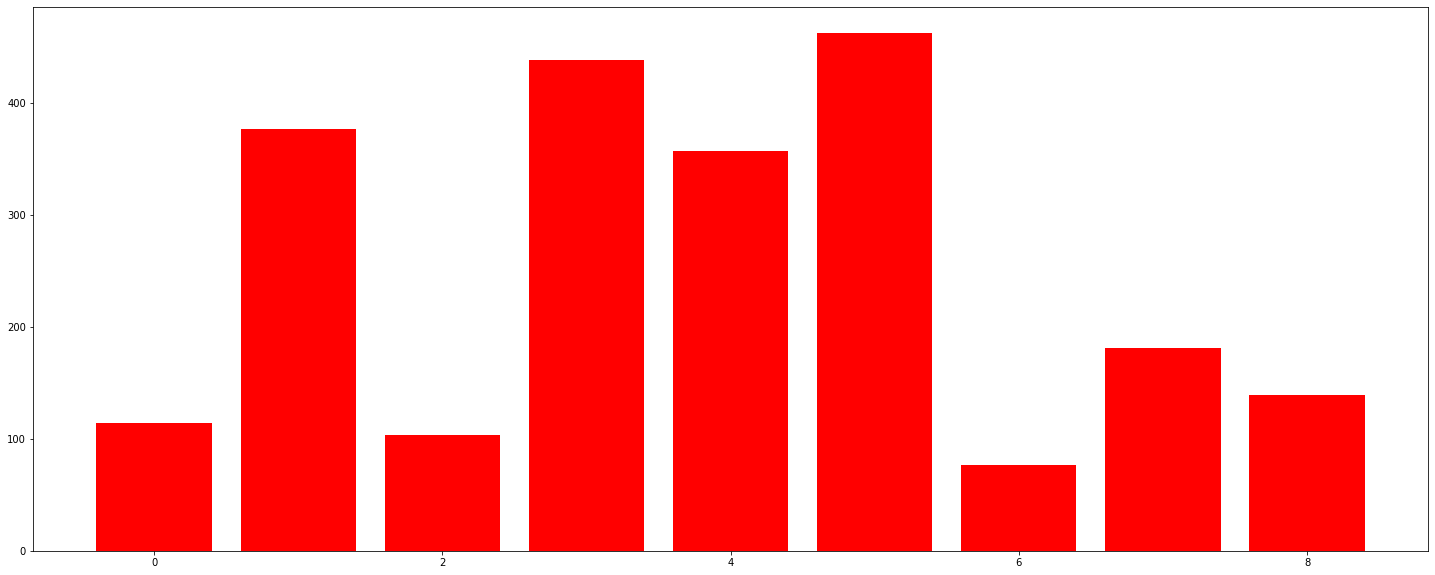

In [26]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
def repl(K):
  if K==0:
    c="actinic keratosis"
  elif K==1:
    c= "basal cell carcinoma"
  elif K==2:
    c="dermatofibroma"
  elif k==3:
    c="melanoma"
  elif k==4:
    c="nevus"
  elif k==5:
    c="pigmented benign keratosis"
  elif k==6:
    c="seborrheic keratosis"
  elif k==7:
    c="squamous cell carcinoma"
  else:
    c="vascular lesion"
  return c

for k,v in counter.items():	
  per = v / len(y) * 100
  repl(k)
  print("class "+ str(k)+ " : " + repl(k)+ ' = %d (%.3f%%)' % ( v, per))


# plot the distribution
plt.figure(figsize=(25, 10))
plt.bar(counter.keys(), counter.values(), color='red')
plt.show()

### Inference:
#### - Which class has the least number of samples?
#### Ans - Dermatofibroma has the least number of samples.

#### - Which classes dominate the data in terms proportionate number of samples?
#### Ans - Pigmented Benign Keratosis and Melanoma are the 2 most dominant clasess.



#### Rectifying the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
datapath="gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(datapath + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA3AB657D0>: 100%|██████████| 500/500 [00:20<00:00, 24.41 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA3A1F6F10>: 100%|██████████| 500/500 [00:21<00:00, 23.16 Samples/s]


Initialised with 103 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA3A2AC850>: 100%|██████████| 500/500 [00:21<00:00, 23.36 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=965x649 at 0x7FBAFD68A350>: 100%|██████████| 500/500 [01:32<00:00,  5.41 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FBA3A22B8D0>: 100%|██████████| 500/500 [01:18<00:00,  6.33 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA3A210FD0>: 100%|██████████| 500/500 [00:18<00:00, 26.76 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBA3AB65B90>: 100%|██████████| 500/500 [00:43<00:00, 11.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA3A1E7F90>: 100%|██████████| 500/500 [00:18<00:00, 26.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA3A2DAFD0>: 100%|██████████| 500/500 [00:18<00:00, 27.60 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000174.jpg_3ba34ce8-96e0-4e80-b46d-d20888593a44.jpg',
 'gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000511.jpg_ee6f6bce-2c2d-40b3-8b29-ddd77ee51b53.jpg',
 'gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010207.jpg_2fb66423-7a63-456b-8fd6-409eb94fab21.jpg',
 'gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000303.jpg_a7d5ce08-65a6-40dc-85ab-2eb48d6b4194.jpg',
 'gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010322.jpg_5ca020cd-4ad4-4dcf-a4ec-a0400ba8b724.jpg',
 'gdrive/My Drive/CNN_ass

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [34]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                603
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [36]:
data_dir_train="gdrive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6747 files belonging to 9 classes.
Using 5398 files for training.


####  Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6747 files belonging to 9 classes.
Using 1349 files for validation.


####  Create your model

In [38]:

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile your model 

In [39]:


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Train your model

In [40]:
epochs = 30
# I am using 30 to see if there is any improvement in accuracy beyond 20 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 46s 72ms/step - loss: 1.9380 - accuracy: 0.2582 - val_loss: 1.6723 - val_accuracy: 0.3847
Epoch 2/30
169/169 [==============================] - 6s 36ms/step - loss: 1.4972 - accuracy: 0.4318 - val_loss: 1.4092 - val_accuracy: 0.4729
Epoch 3/30
169/169 [==============================] - 6s 37ms/step - loss: 1.2325 - accuracy: 0.5415 - val_loss: 1.1822 - val_accuracy: 0.5493
Epoch 4/30
169/169 [==============================] - 6s 37ms/step - loss: 1.0596 - accuracy: 0.6099 - val_loss: 1.0779 - val_accuracy: 0.6123
Epoch 5/30
169/169 [==============================] - 6s 36ms/step - loss: 0.9362 - accuracy: 0.6560 - val_loss: 0.9067 - val_accuracy: 0.6694
Epoch 6/30
169/169 [==============================] - 6s 37ms/step - loss: 0.8148 - accuracy: 0.6973 - val_loss: 0.8305 - val_accuracy: 0.7109
Epoch 7/30
169/169 [==============================] - 7s 39ms/step - loss: 0.6785 - accuracy: 0.7549 - val_loss: 0.8750 - val_accuracy: 0.685

#### Visualize the model results

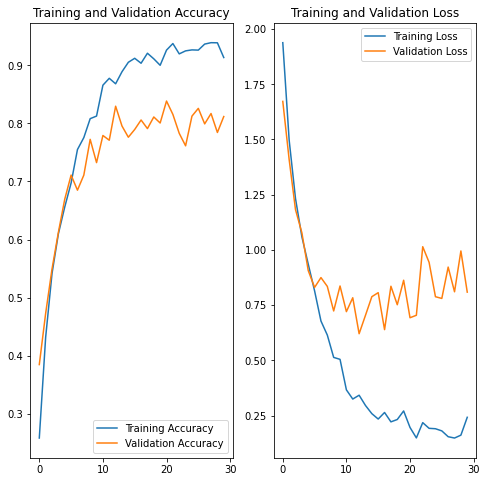

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

### Inference:
We see that the validation accuracy has improved to > 80%. Though we still see a difference of more than 10% between the training and validation accuracy. 
This shows that we do not have the overfitting/underfitting problem, and the class rebalance defintely helped. 
However, we can look further into improving the model by using transfer learning.